# Project 02 #

## Anisotropic Diffusion ##

Due: November 12th at 11:59 PM

By: Shane Houghton and Richie Glennon

In [1]:
# Common imports
import numpy as np
import skimage as ski
import skimage.io as io
import scipy.ndimage as ndi
from skimage.util import random_noise
import matplotlib.pylab as plt
plt.gray() # set default to grayscale

<Figure size 432x288 with 0 Axes>

**Describe the mathematics behind the filter. Not every equation is necessary, but most should be included, possibly organized in a way to make the code more readable**


$\begin{gather}
I_{s}^{t+1} \approx I_{s}^{t} +\frac{\lambda }{|\eta _{s} |}\sum g\left( |\triangledown I_{s,p}^{t} |, \gamma \right) \triangledown I_{s,p}^{t}\tag{1}\\
\end{gather}$


$\begin{gather}
g( x,\gamma ) =\ \left\{\left[ 1-\left( x^{2} /5\gamma ^{2}\right)\right]^{2} \ where\ |x|\ \leq \ \gamma \sqrt{5} ,\ 0\ otherwise\ \right\}\tag{2}\\
\end{gather}$

Equations source:

https://www.sciencedirect.com/science/article/pii/S147466701642210X

* $I_{s}^{t+1}$: the output blurred image (or for an itermediate iteration it's the next image to be used).
* $\triangledown I_{s,p}^{t}$: The gradient from pixel s to p
* $t$: the current iteration
* $s$: the current pixel 
* $\lambda$: positive constant for the diffusion rate
* $\eta _s$: the neighborhood of pixel s
* $\gamma$: positive constant for the desired smoothing level


**Describe the purpose of the filter, i.e. what it is used for and what is the output of the filter.**

Anisotropic Diffusion (Perona–Malik diffusion) is an edge preserving noise reduction method. Using the edge stopping funtion described above, the filter is able to blur areas of lower frequency and keep high frequency important features like edges. Anisotrophic Diffusion is an iterative process similar to the blind deconvolution project where we specify the number of iteraitons to be used on the image and the described process is repeated. The output of the filter function is the blurred image as a floating point array.

**Describe how it works (e.g. first-order edge detectors work because edges are large values in the derivative of the image, but you have to write way more detail)**

The filter works by calculating the difference between each pixel and its neighbors. Then each gradient value is put into the Edge Stopping Function G. G is a piecewise function where If the inputted difference is lower than the value calculated from the gamma value, that means the area is not an edge, so G returns its normal output "blurring" that part of the image. If the difference is high, then the pixel is an edge and G returns 0 in order to preserve its sharpness.


Text(0.5, 1.0, 'Gradient Calculation')

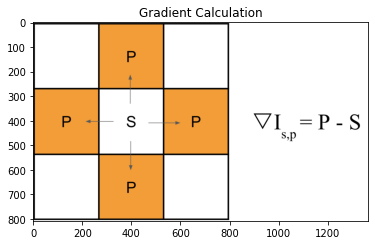

In [2]:
neighborhood = io.imread('Neighborhood.png')
plt.imshow(neighborhood)
plt.title("Gradient Calculation")

**Implementing the filter as a self-contained function taking the image as the first argument and any additional parameters, preferably with reasonable default values.**

In [3]:
def anisotropic_diffusion(im, gamma, lam, niter=10):
    """
    Performs anisotropic diffusion on the given image

    Parameters
    ----------
    * im - the input image to be diffused
    * gam - gamma: positive constant selected according to the smoothing level. should not exceed 1/7
    * lam - lambda: constant related to the diffusion rate

    * niter - (optional): number of iterations 

    Returns
    -------
    imout - the diffused image
    """


    def g(x,y):
        """
        ESF - edge stopping function

        Parameters
        ----------
        * x - gradient
        * y - gamma value
        """

        return np.where(x <= y * np.sqrt(5), (1 - ((x**2)/5*(y**2)))**2, 0)

    im = ski.img_as_float(im)
    h, w = im.shape

    for _ in range(niter):
        im = np.pad(im, 1) #pad the image with 1 pixel around
        T = []
        Ip = [(slice(None,None), slice(1,None)),
            (slice(None,-1), slice(None,None)),
            (slice(None,None), slice(None,-1)),
            (slice(1,None), slice(None,None))
        ]

        Is = [
            (slice(None, None), slice(None,-1)),  # 1:h+1, 1:w+1
            (slice(1, None), slice(None, None)),  # :h, 1:w+1
            (slice(None, None), slice(1, None)),  # 1:h+1, :w
            (slice(None, -1), slice(None, None)) # 1:h+1, 1:w+1
        ]

        for (sli1, sli2) in zip(Ip, Is):

            if (sli2[0].start == None) and (sli2[1].start == None):
                gradient = (im[sli1] - im[sli2])[1:h+1, 1:w+1]
            elif (sli2[0].start == None) and (sli2[1].start == 1):
                gradient = (im[sli1] - im[sli2])[1:h+1, :w]
            elif (sli2[0].start == 1) and (sli2[1].start == None):
                gradient = (im[sli1] - im[sli2])[:h, 1:w+1]

            T.append(gradient * g(np.abs(gradient), gamma))

        imout = im[1:h+1, 1:w+1] + (lam / 4) * np.dstack(T).sum(2) # magnitude of eta = 4 because 4 connected
        im = imout

    return imout

In [4]:
Ip = [
(slice(None,None), slice(1,None)), 
(slice(None,-1), slice(None,None)),
(slice(None,None), slice(None,-1)),
(slice(1,None), slice(None,None)),
]

Is = [
(slice(None, None), slice(None,-1)),
(slice(None, 1), slice(None, None)),
(slice(None, None), slice(None, 1)),
(slice(None, -1), slice(None, None)),
]

print((slice(None,None), slice(1,None))[0])


slice(None, None, None)


In [10]:
im = np.arange(9).reshape(3,3)
im

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [6]:
im[Is[0]] - im[Ip[0]]

array([[-1, -1],
       [-1, -1],
       [-1, -1]])

**Demonstration of the filter on images of your choosing with different parameter values. If possible, include example of where the filter “fails”.**

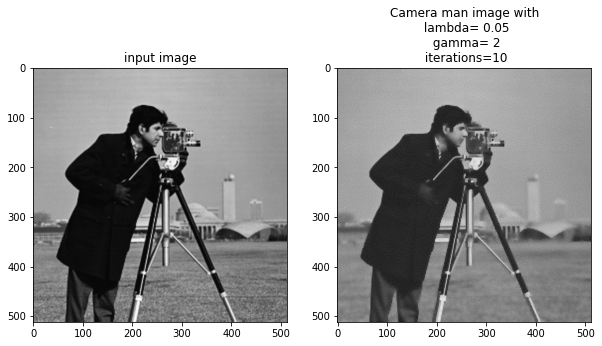

In [14]:
im = io.imread("cameraman.tif")
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(im)
plt.title("input image")
out = anisotropic_diffusion(im, 0.05, 2, niter=10)

plt.subplot(1,2,2)
plt.title("Camera man image with\n lambda= 0.05\n gamma= 2\n iterations=10") 
plt.imshow(out)

As seen from the images above, the diffused image is blurrier and slighlty brighter, but the edges remain rather sharp. This is seen especially on the cameraman's coat and the tripod. Features like the grass and his face have been blurred.

Text(0.5, 1.0, 'Difference between original image and Anistropic Diffused image.')

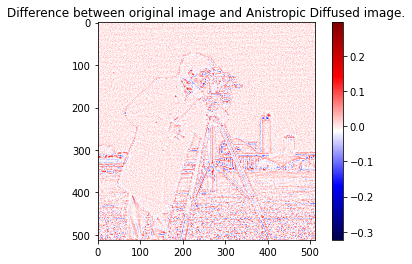

In [13]:
plt.imshow(im/255-out, cmap='seismic')
plt.colorbar()
plt.title('Difference between original image and Anistropic Diffused image.')

**Demonstration of the filter on noisy images (salt and pepper and Gaussian noise), providing recommendations for preprocessing steps to deal with possible noise in images.**

Text(0.5, 1.0, 'Median and Anisotropic Diffusion')

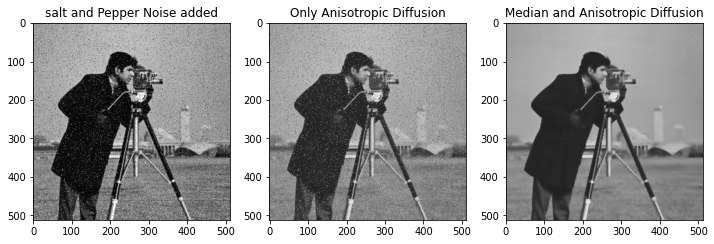

In [8]:
plt.figure(figsize=(12,12))
noisy = random_noise(im, mode='s&p', amount=0.05)
plt.subplot(1,3,1)
plt.imshow(noisy)
plt.title("salt and Pepper Noise added")

out = anisotropic_diffusion(noisy, 0.05, 2, 10)
plt.subplot(1,3,2)
plt.imshow(out)
plt.title("Only Anisotropic Diffusion")


out = anisotropic_diffusion(ndi.median_filter(noisy, 3), 0.05, 2, 10)
plt.subplot(1,3,3)
plt.imshow(out)
plt.title("Median and Anisotropic Diffusion")

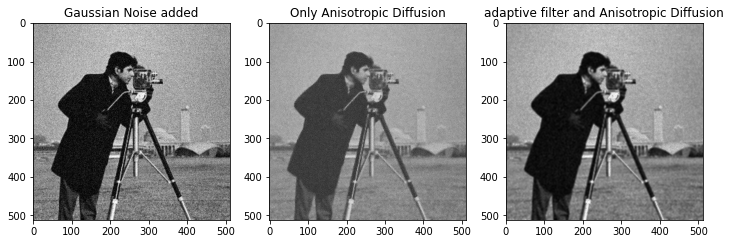

In [23]:
plt.figure(figsize=(12,12))
noisy = random_noise(im, mode='gaussian', var=0.01)
plt.subplot(1,3,1)
plt.imshow(noisy)
plt.title("Gaussian Noise added")

out = anisotropic_diffusion(noisy, 0.1, 2, 5)
plt.subplot(1,3,2)
plt.imshow(out)
plt.title("Only Anisotropic Diffusion")

# Gaussian noise removal with an adaptive filter
sz = (5,5) #sz of the kernel
m = ndi.uniform_filter(noisy, sz)
var = ndi.convolve(noisy*noisy, np.ones(sz))/(sz[0]*sz[1]-m*m)
n = var.mean()
f = np.maximum(0, var -n)/ np.maximum(var,n)
ad_out = m + f * (noisy - m)

plt.subplot(1,3,3)
plt.title("adaptive filter and Anisotropic Diffusion")
plt.imshow(ad_out)
